# <b> Churn Prediction Machine Leaning Model

## <b> Import Necessary Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, log_loss
import pickle
import lime
import lime.lime_tabular
import shap
from imblearn.over_sampling import SMOTE

## <b> Loading Dataset

In [9]:
# Load the dataset
data = pd.read_csv('dataset/churn_modeling.csv')

## <b> Exploring Dataset

In [10]:
# Display the first few rows of the dataset
print(data.head())

# Display basic information about the dataset
print(data.info())

# Check for missing values
print(data.isnull().sum())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

## <b> Data Visualization

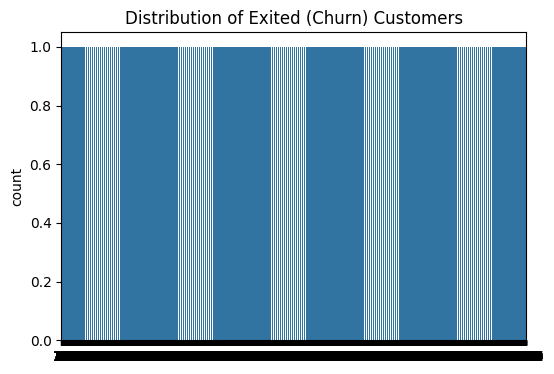

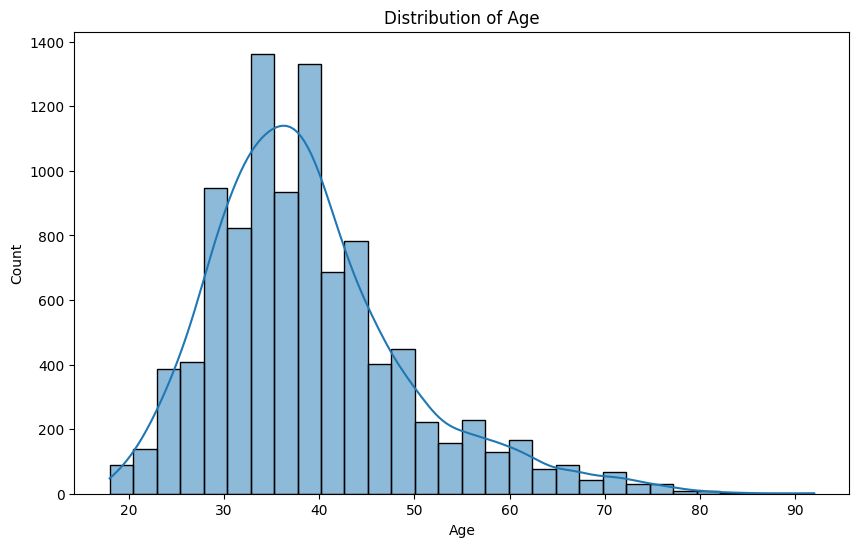

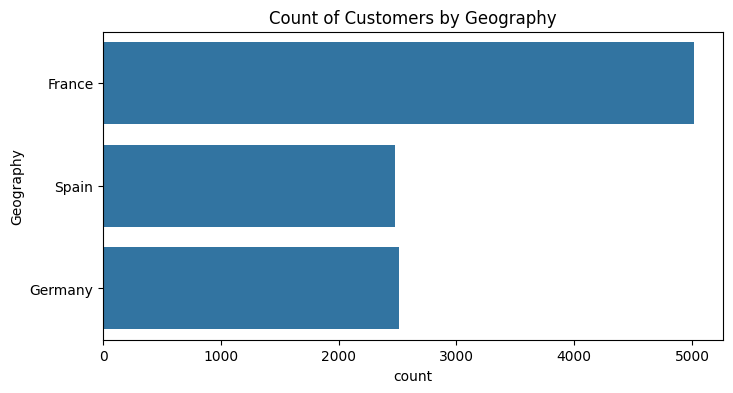

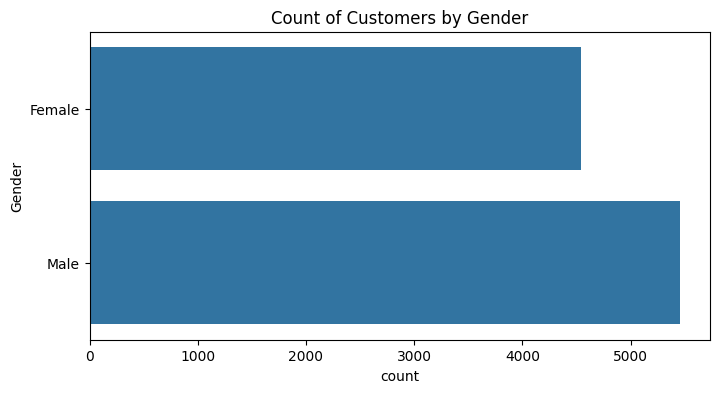

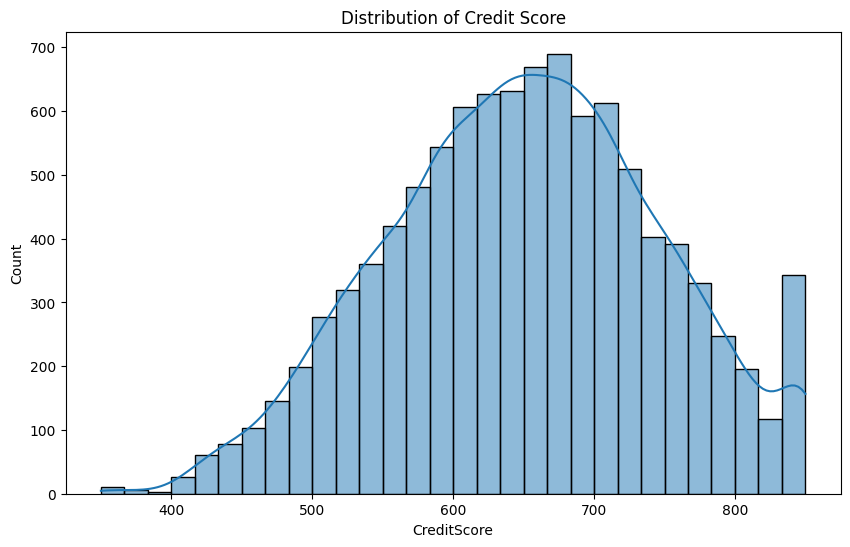

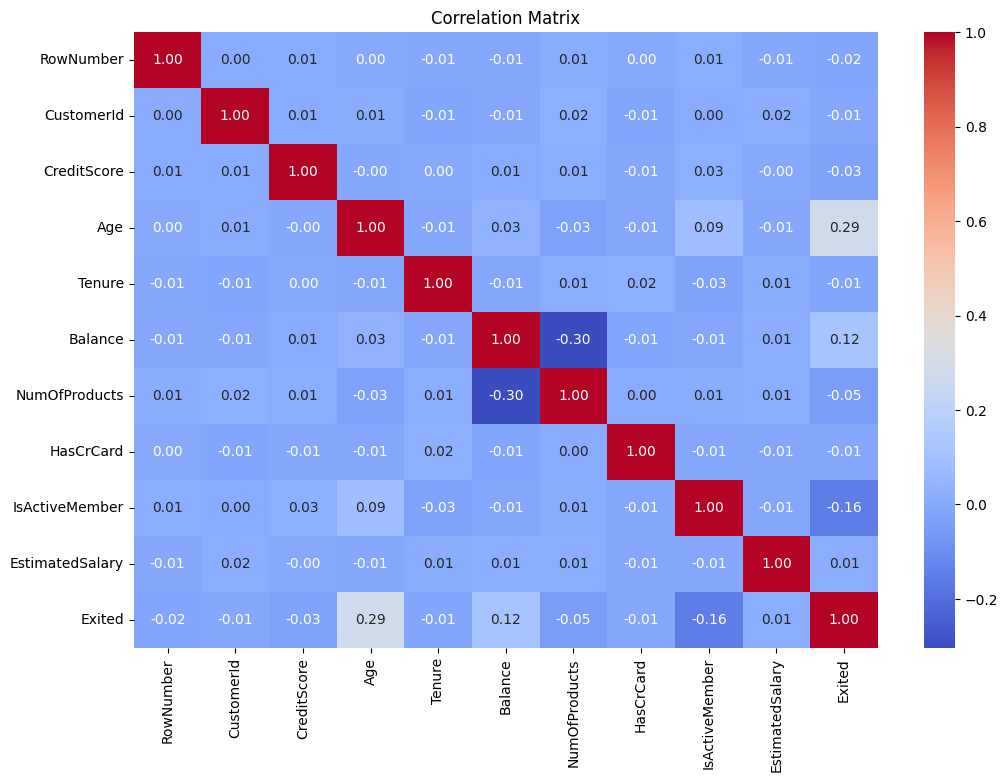

In [11]:
# Plot the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(data['Exited'])
plt.title('Distribution of Exited (Churn) Customers')
plt.show()

# Plot the distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(data['Age'], bins=30, kde=True)
plt.title('Distribution of Age')
plt.show()

# Plot the count of customers by Geography
plt.figure(figsize=(8, 4))
sns.countplot(data['Geography'])
plt.title('Count of Customers by Geography')
plt.show()

# Plot the count of customers by Gender
plt.figure(figsize=(8, 4))
sns.countplot(data['Gender'])
plt.title('Count of Customers by Gender')
plt.show()

# Plot the distribution of CreditScore
plt.figure(figsize=(10, 6))
sns.histplot(data['CreditScore'], bins=30, kde=True)
plt.title('Distribution of Credit Score')
plt.show()

# Plot the correlation matrix for numeric features only
numeric_features = data.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_features.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## <b> Data Preprocessing

In [12]:
# Encode categorical variables
label_encoder = LabelEncoder()
data['Geography'] = label_encoder.fit_transform(data['Geography'])
data['Gender'] = label_encoder.fit_transform(data['Gender'])

# Drop irrelevant columns
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Split the data into features and target variable
X = data.drop('Exited', axis=1)
y = data['Exited']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle imbalanced data using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)

## <b>Train Multiple Models

In [13]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    results[name] = {
        'Accuracy': acc,
        'ROC AUC': roc_auc,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'Classification Report': classification_report(y_test, y_pred)
    }

# Display results
for name, metrics in results.items():
    print(f'Model: {name}')
    print(f'Accuracy: {metrics["Accuracy"]}')
    print(f'ROC AUC: {metrics["ROC AUC"]}')
    print(f'F1 Score: {metrics["F1 Score"]}')
    print(f'Precision: {metrics["Precision"]}')
    print(f'Recall: {metrics["Recall"]}')
    print('Confusion Matrix:')
    print(metrics['Confusion Matrix'])
    print('Classification Report:')
    print(metrics['Classification Report'])
    print('-----------------------------------------------------')

Model: Logistic Regression
Accuracy: 0.733
ROC AUC: 0.7418276592072532
F1 Score: 0.463855421686747
Precision: 0.38308457711442784
Recall: 0.5877862595419847
Confusion Matrix:
[[1235  372]
 [ 162  231]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1607
           1       0.38      0.59      0.46       393

    accuracy                           0.73      2000
   macro avg       0.63      0.68      0.64      2000
weighted avg       0.79      0.73      0.75      2000

-----------------------------------------------------
Model: Random Forest
Accuracy: 0.8255
ROC AUC: 0.8337972705292208
F1 Score: 0.5955967555040557
Precision: 0.5468085106382978
Recall: 0.6539440203562341
Confusion Matrix:
[[1394  213]
 [ 136  257]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1607
           1       0.55      0.65      0.60       393

    accura

## <b> Hyperparameter Tuning

In [14]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_smote, y_train_smote)

# Best parameters and score
print('Best Parameters:', grid_search.best_params_)
print('Best Score:', grid_search.best_score_)

# Evaluate the tuned model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print('Tuned Random Forest')
print('Accuracy:', acc)
print('ROC AUC:', roc_auc)
print('F1 Score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 108 candidates, totalling 324 fits


Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.8435400157470264
Tuned Random Forest
Accuracy: 0.818
ROC AUC: 0.838730363818599
F1 Score: 0.5891647855530474
Precision: 0.5294117647058824
Recall: 0.6641221374045801
Confusion Matrix:
[[1375  232]
 [ 132  261]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1607
           1       0.53      0.66      0.59       393

    accuracy                           0.82      2000
   macro avg       0.72      0.76      0.74      2000
weighted avg       0.84      0.82      0.83      2000



## <b> Feature Importance Analysis

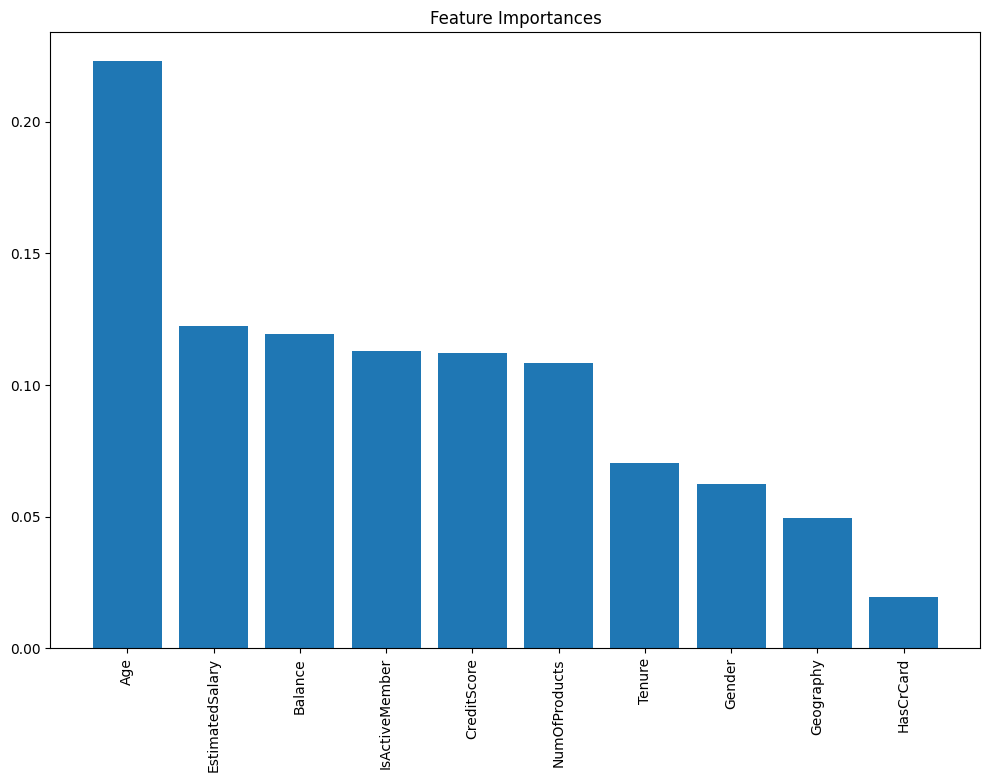

In [15]:
# Feature importance for Random Forest
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.show()

## <b> SHAP Values for Model Interpretability

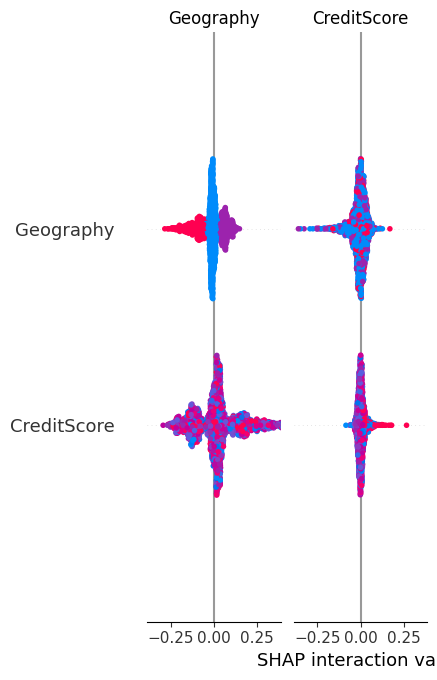

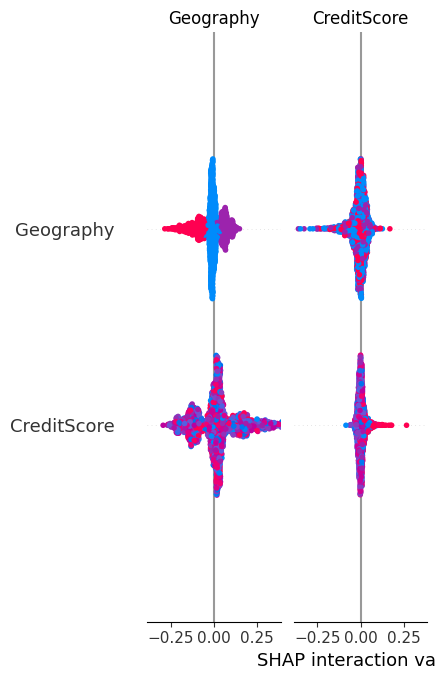

In [16]:
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features)
shap.summary_plot(shap_values, X_test, feature_names=features, plot_type='bar')

## <b> Save and Load the Model

In [17]:
# Save the model to disk
filename = 'ML_Model/best_rf_model.sav'
pickle.dump(best_rf, open(filename, 'wb'))

# Load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(f'Loaded model score: {result}')

Loaded model score: 0.818


## <b> Creating a Pipeline

In [18]:
# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the pipeline
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print('Pipeline Random Forest')
print('Accuracy:', acc)
print('ROC AUC:', roc_auc)
print('F1 Score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

Pipeline Random Forest
Accuracy: 0.6215
ROC AUC: 0.5142031284884356
F1 Score: 0.260019550342131
Precision: 0.2111111111111111
Recall: 0.3384223918575064
Confusion Matrix:
[[1110  497]
 [ 260  133]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.69      0.75      1607
           1       0.21      0.34      0.26       393

    accuracy                           0.62      2000
   macro avg       0.51      0.51      0.50      2000
weighted avg       0.69      0.62      0.65      2000



c:\GitHub\Churn-Prediction-Machine-Leaning-Model\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\GitHub\Churn-Prediction-Machine-Leaning-Model\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## <b> Voting Classifier

In [19]:
voting_clf = VotingClassifier(estimators=[
    ('lr', LogisticRegression(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
], voting='soft')

voting_clf.fit(X_train_smote, y_train_smote)
y_pred = voting_clf.predict(X_test)
y_pred_proba = voting_clf.predict_proba(X_test)[:, 1]

## <b> Model Evaluation Metrics

In [20]:
mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred_proba)

print('Voting Classifier Metrics')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred_proba))
print('F1 Score:', f1_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('MCC:', mcc)
print('Kappa:', kappa)
print('Log Loss:', logloss)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

Voting Classifier Metrics
Accuracy: 0.8055
ROC AUC: 0.8371406268060695
F1 Score: 0.5682574916759157
Precision: 0.5039370078740157
Recall: 0.6513994910941476
MCC: 0.4514704932305972
Kappa: 0.4453601309463382
Log Loss: 0.42965237829029435
Confusion Matrix:
[[1355  252]
 [ 137  256]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1607
           1       0.50      0.65      0.57       393

    accuracy                           0.81      2000
   macro avg       0.71      0.75      0.72      2000
weighted avg       0.83      0.81      0.81      2000



## <b> Learning Curves

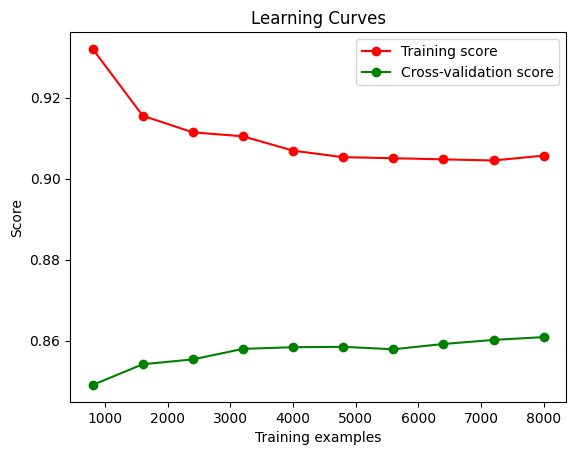

In [21]:
train_sizes, train_scores, test_scores = learning_curve(voting_clf, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

## <b> LIME for Model Explainability

In [22]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_smote, feature_names=X.columns, class_names=['Not Exited', 'Exited'], verbose=True, mode='classification')
idx = 1  # example instance index to explain
exp = explainer.explain_instance(X_test[idx], voting_clf.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)

Intercept 0.5832396146855867
Prediction_local [0.20289289]
Right: 0.0650191473419174


## <b> Save and Load the Ensemble Model

In [25]:
filename = 'ML_Model/voting_classifier_model.sav'
pickle.dump(voting_clf, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(f'Loaded Voting Classifier model score: {result}')


Loaded Voting Classifier model score: 0.8055


## <b> Cross-Validation

In [26]:
# Cross-validation for Random Forest
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy')

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {cv_scores.mean()}')
print(f'Standard deviation of cross-validation score: {cv_scores.std()}')

Cross-validation scores: [0.8545 0.855  0.859  0.867  0.858 ]
Mean cross-validation score: 0.8587
Standard deviation of cross-validation score: 0.004489988864128723


## <b> Time-Series Cross-Validation

In [27]:
tscv = TimeSeriesSplit(n_splits=5)
tscv_scores = cross_val_score(rf_model, X, y, cv=tscv, scoring='accuracy')

print(f'Time-series cross-validation scores: {tscv_scores}')
print(f'Mean time-series cross-validation score: {tscv_scores.mean()}')
print(f'Standard deviation of time-series cross-validation score: {tscv_scores.std()}')

Time-series cross-validation scores: [0.85654262 0.8577431  0.85594238 0.86494598 0.85354142]
Mean time-series cross-validation score: 0.8577430972388956
Standard deviation of time-series cross-validation score: 0.003852774678482889
